In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

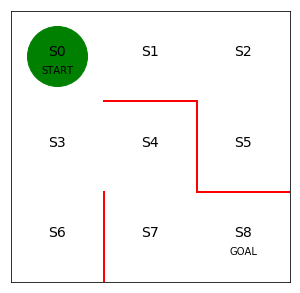

In [3]:
# 初期状態での迷路の様子

# 図を描く大きさと、図の変数を宣言。
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# make wall
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# make points
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定とメモリを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地に丸を描画する。
line, = ax.plot([0.5], [2.5], 'o', color = 'g', markersize=60)

In [4]:
# 初期の方策を決定するparams theta_0を設定

# 行は0~7, 列は移動方向で上右下左を表す。
theta_0 = np.array([[np.nan, 1, 1, np.nan],  
                   [np.nan, 1, np.nan, 1],
                    [np.nan, np.nan, 1, 1],
                   [1, 1, 1, np.nan],        
                   [np.nan, np.nan, 1, 1],   
                   [1, np.nan, np.nan, np.nan],  
                   [1, np.nan, np.nan, np.nan],  
                   [1, 1, np.nan, np.nan],       
                    ])

# 方策反復法の実装
強化学習の方策反復法を実装する。
ランダムで移動する方策を実装したが、ここからエージェントが一直線にゴールへ移動するために考える。
方策に従って行動しゴールした時に、早くゴールできたケースで実行した行動(action)は重要だと考え、その行動を多く取り入れるようにする方策を更新する作戦。
->**方策反復法**

### 方策を求める方法を変更する
今まではθを割合に変換し、方策としていた。
今回はソフトマックス関数を使用する。
$$
P(θ_i) = {\frac{exp(βθ_i)}{{\sum_(j=1)^(N_a)}exp(βθ_j)}}
$$
ソフトマックス関数は逆温度βが小さいほど行動がよりランダムになるという性質がある。

In [6]:
def softmax_convert_into_pi_from_theta(theta):
    
    beta = 1.0
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    
    exp_theta = np.exp(beta * theta)
    
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
    
    # pi = np.nan_to_sum(pi)
    pi = np.where( np.isnan(pi),0,pi)
    
    return pi

In [7]:
pi_0 = softmax_convert_into_pi_from_theta(theta_0)

In [8]:
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

### 方策に従ってエージェントを移動させる関数
今回はどの行動が有効だったかをフィードバックするために、
どの行動をとったかを示すactionを用意する。

In [9]:
def get_action_and_next_s(pi, s):
    direction = ['up', 'right', 'down', 'left']
    next_direction = np.random.choice(direction, p=pi[s, :])
    
    if next_direction == 'up':
        action = 0
        s_next = s - 3
    elif next_direction == 'right':
        action = 1
        s_next = s + 1
    elif next_direction == 'down':
        action = 2
        s_next = s + 3
    elif next_direction == 'left':
        action = 3
        s_next = s - 1
    
    return [action, s_next]

In [12]:
def get_action_and_next_s_2nd(pi, s):
    direction = ["up", "right", "down", "left"]
    # pi[s,:]の確率に従って、directionが選択される
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return [action, s_next]

In [34]:
def goal_maze_ret_s_a(pi):
    s = 0
    s_a_history = [[0, np.nan]]
    
    while (1):  # ゴールするまでループ
        [action, next_s] = get_action_and_next_s_2nd(pi, s)
        s_a_history[-1][1] = action  # 現在の状況を入力。一番最後に撮った行動なので[-1]
        
        s_a_history.append([next_s, np.nan])
        
        if next_s == 8:
            break
        else:
            s = next_s
            
    return s_a_history

In [25]:

def goal_maze_ret_s_a_2nd(pi):
    s = 0  # スタート地点
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        [action, next_s] = get_action_and_next_s_2nd(pi, s)
        s_a_history[-1][1] = action
        # 現在の状態（つまり一番最後なのでindex=-1）の行動を代入

        s_a_history.append([next_s, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        if next_s == 8:  # ゴール地点なら終了
            break
        else:
            s = next_s

    return s_a_history

In [38]:
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print('迷路を解くのにかかったステップ数は' + str(len(s_a_history) - 1) + 'です。')

[[0, 2], [3, 2], [6, 0], [3, 2], [6, 0], [3, 1], [4, 3], [3, 2], [6, 0], [3, 0], [0, 1], [1, 3], [0, 2], [3, 2], [6, 0], [3, 2], [6, 0], [3, 2], [6, 0], [3, 0], [0, 1], [1, 3], [0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 0], [0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 2], [6, 0], [3, 0], [0, 2], [3, 1], [4, 2], [7, 0], [4, 3], [3, 1], [4, 3], [3, 2], [6, 0], [3, 2], [6, 0], [3, 2], [6, 0], [3, 0], [0, 1], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 0], [0, 1], [1, 3], [0, 1], [1, 3], [0, 2], [3, 2], [6, 0], [3, 1], [4, 3], [3, 1], [4, 3], [3, 2], [6, 0], [3, 2], [6, 0], [3, 2], [6, 0], [3, 0], [0, 2], [3, 0], [0, 2], [3, 2], [6, 0], [3, 0], [0, 1], [1, 3], [0, 1], [1, 3], [0, 1], [1, 3], [0, 2], [3, 0], [0, 2], [3, 2], [6, 0], [3, 1], [4, 3], [3, 2], [6, 0],

In [43]:
s_a_history[1]

[3, 2]

In [47]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    state = s_a_history[i][0] # 現在の座標を描く
    x = (state %3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history),
                              interval=200, repeat=True)

HTML(anim.to_jshtml())

# 方策勾配法に従い方策を更新
方策勾配法に従い方策を更新する。
$$
θ_((s_i),(a_j)) = θ_((s_i),(a_j)) + n
$$

In [52]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1  # 学習率
    T = len(s_a_history) - 1
    
    [m, n] = theta.shape
    delta_theta = theta.copy()  # Δthetaの元を作成。numpyはCでできていて、ポインタを実装しているので = だとどうメモリを参照してしまう。
    
    # delta_thetaを要素ごとに求める
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # thetaがnanでない場合
                
                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 履歴からiのものを取り出す内包表記
                
                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 履歴からi, jのものを取り出す内包表記
                
                N_i = len(SA_i) # 状態iで行動した総回数
                N_ij = len(SA_ij) # 状態ijで行動した総回数
                
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T
    
    net_theta = theta + eta * delta_theta
    
    return net_theta
                
    

In [53]:
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[0.         0.50064935 0.49935065 0.        ]
 [0.         0.49902598 0.         0.50097402]
 [0.         0.         0.49935065 0.50064935]
 [0.33347648 0.33217975 0.33434378 0.        ]
 [0.         0.         0.49935065 0.50064935]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


## 探索とパラメータの更新を規定値まで繰り返すプログラム

In [55]:
step_epsilon = 10**-4  # 10^-4よりもパラメータの変化の値が小さくなったら更新を終了する。

theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:
    s_a_history = goal_maze_ret_s_a(pi)  # 方策piで迷路内を探索したログを収める。
    new_theta = update_theta(theta, pi, s_a_history)
    new_pi = softmax_convert_into_pi_from_theta(new_theta)
    
    print(np.sum(np.abs(new_pi - pi)))  # 方策の変化を出力
    print('試行' + str(count) + '回目で、迷路を解くまでにかかったStep数は' + str(len(s_a_history) - 1) + 'です。')
    
    if np.sum(np.sum(np.abs(new_pi - pi))) < step_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi
        count += 1

0.014768847522971862
試行1回目で、迷路を解くまでにかかったStep数は38です。
0.005166916964545409
試行2回目で、迷路を解くまでにかかったStep数は80です。
0.014420829204193575
試行3回目で、迷路を解くまでにかかったStep数は24です。
0.0055744916123912636
試行4回目で、迷路を解くまでにかかったStep数は206です。
0.008965270831188255
試行5回目で、迷路を解くまでにかかったStep数は26です。
0.010984949625976737
試行6回目で、迷路を解くまでにかかったStep数は64です。
0.012547670039809222
試行7回目で、迷路を解くまでにかかったStep数は32です。
0.00848225343595177
試行8回目で、迷路を解くまでにかかったStep数は94です。
0.007645413475429186
試行9回目で、迷路を解くまでにかかったStep数は46です。
0.008961232955761067
試行10回目で、迷路を解くまでにかかったStep数は78です。
0.015603288970154061
試行11回目で、迷路を解くまでにかかったStep数は28です。
0.005622190021325968
試行12回目で、迷路を解くまでにかかったStep数は302です。
0.012350620981732896
試行13回目で、迷路を解くまでにかかったStep数は92です。
0.019188791217981116
試行14回目で、迷路を解くまでにかかったStep数は24です。
0.008192900230658884
試行15回目で、迷路を解くまでにかかったStep数は50です。
0.01892562708605927
試行16回目で、迷路を解くまでにかかったStep数は40です。
0.010096144831140297
試行17回目で、迷路を解くまでにかかったStep数は36です。
0.004943765622923091
試行18回目で、迷路を解くまでにかかったStep数は158です。
0.032424505255861436
試行19回目で、迷路を解くまでにかかったStep数は6です。
0

0.015556274697392652
試行251回目で、迷路を解くまでにかかったStep数は26です。
0.012800903973926636
試行252回目で、迷路を解くまでにかかったStep数は18です。
0.016161115647958108
試行253回目で、迷路を解くまでにかかったStep数は14です。
0.020358989583934506
試行254回目で、迷路を解くまでにかかったStep数は10です。
0.01948549112038961
試行255回目で、迷路を解くまでにかかったStep数は6です。
0.022416888029857196
試行256回目で、迷路を解くまでにかかったStep数は12です。
0.024223194106533202
試行257回目で、迷路を解くまでにかかったStep数は4です。
0.016260441814297866
試行258回目で、迷路を解くまでにかかったStep数は16です。
0.02393250420887591
試行259回目で、迷路を解くまでにかかったStep数は4です。
0.023580040625047066
試行260回目で、迷路を解くまでにかかったStep数は4です。
0.016293694415807053
試行261回目で、迷路を解くまでにかかったStep数は8です。
0.01864385151583392
試行262回目で、迷路を解くまでにかかったStep数は12です。
0.023201527067129746
試行263回目で、迷路を解くまでにかかったStep数は4です。
0.017887908870507563
試行264回目で、迷路を解くまでにかかったStep数は20です。
0.01627440040803796
試行265回目で、迷路を解くまでにかかったStep数は8です。
0.015994655502446276
試行266回目で、迷路を解くまでにかかったStep数は8です。
0.022902672941092772
試行267回目で、迷路を解くまでにかかったStep数は4です。
0.02294356234249731
試行268回目で、迷路を解くまでにかかったStep数は10です。
0.02253690320158727
試行269回目で、迷路を解くまでにかかったS

0.012343447926117482
試行470回目で、迷路を解くまでにかかったStep数は6です。
0.012789517540992307
試行471回目で、迷路を解くまでにかかったStep数は4です。
0.012621998667743328
試行472回目で、迷路を解くまでにかかったStep数は4です。
0.014621844517794441
試行473回目で、迷路を解くまでにかかったStep数は8です。
0.012485172778147119
試行474回目で、迷路を解くまでにかかったStep数は4です。
0.0123232120860121
試行475回目で、迷路を解くまでにかかったStep数は4です。
0.015059269978849613
試行476回目で、迷路を解くまでにかかったStep数は10です。
0.023482060318124873
試行477回目で、迷路を解くまでにかかったStep数は8です。
0.012345228664048843
試行478回目で、迷路を解くまでにかかったStep数は4です。
0.017618369989438637
試行479回目で、迷路を解くまでにかかったStep数は6です。
0.014609611410434695
試行480回目で、迷路を解くまでにかかったStep数は30です。
0.01230024440959969
試行481回目で、迷路を解くまでにかかったStep数は4です。
0.01214141603296072
試行482回目で、迷路を解くまでにかかったStep数は4です。
0.014811643904929159
試行483回目で、迷路を解くまでにかかったStep数は10です。
0.012078428451178819
試行484回目で、迷路を解くまでにかかったStep数は4です。
0.014894156417136761
試行485回目で、迷路を解くまでにかかったStep数は10です。
0.013624240921735281
試行486回目で、迷路を解くまでにかかったStep数は10です。
0.01185545365199217
試行487回目で、迷路を解くまでにかかったStep数は6です。
0.02194502741415562
試行488回目で、迷路を解くまでにかかったStep数

0.012902632498934169
試行712回目で、迷路を解くまでにかかったStep数は8です。
0.005634606390443456
試行713回目で、迷路を解くまでにかかったStep数は4です。
0.005579817092625491
試行714回目で、迷路を解くまでにかかったStep数は4です。
0.005525766491419781
試行715回目で、迷路を解くまでにかかったStep数は4です。
0.009594230188770328
試行716回目で、迷路を解くまでにかかったStep数は6です。
0.0072954489260820266
試行717回目で、迷路を解くまでにかかったStep数は6です。
0.005511668998870678
試行718回目で、迷路を解くまでにかかったStep数は4です。
0.009888615225618846
試行719回目で、迷路を解くまでにかかったStep数は8です。
0.005496592818732229
試行720回目で、迷路を解くまでにかかったStep数は4です。
0.0054436496354155345
試行721回目で、迷路を解くまでにかかったStep数は4です。
0.005391415457902324
試行722回目で、迷路を解くまでにかかったStep数は4です。
0.010121509410060348
試行723回目で、迷路を解くまでにかかったStep数は10です。
0.0054072788718192155
試行724回目で、迷路を解くまでにかかったStep数は4です。
0.005355521343843872
試行725回目で、迷路を解くまでにかかったStep数は4です。
0.005304453018481606
試行726回目で、迷路を解くまでにかかったStep数は4です。
0.005254062603685369
試行727回目で、迷路を解くまでにかかったStep数は4です。
0.005204339016920814
試行728回目で、迷路を解くまでにかかったStep数は4です。
0.005155271381122137
試行729回目で、迷路を解くまでにかかったStep数は4です。
0.005106849020726306
試行730回目で、迷路を解くまでにかかった

0.007852260862270935
試行962回目で、迷路を解くまでにかかったStep数は8です。
0.002347161398536128
試行963回目で、迷路を解くまでにかかったStep数は4です。
0.0023314250400916572
試行964回目で、迷路を解くまでにかかったStep数は4です。
0.0023158411921696265
試行965回目で、迷路を解くまでにかかったStep数は4です。
0.005542090395503331
試行966回目で、迷路を解くまでにかかったStep数は6です。
0.0056799345008504976
試行967回目で、迷路を解くまでにかかったStep数は6です。
0.006143650322924396
試行968回目で、迷路を解くまでにかかったStep数は8です。
0.005009630314827866
試行969回目で、迷路を解くまでにかかったStep数は6です。
0.005671564595189353
試行970回目で、迷路を解くまでにかかったStep数は6です。
0.002403855932269161
試行971回目で、迷路を解くまでにかかったStep数は4です。
0.0023875530191991845
試行972回目で、迷路を解くまでにかかったStep数は4です。
0.0023714099049006038
試行973回目で、迷路を解くまでにかかったStep数は4です。
0.007009639102721607
試行974回目で、迷路を解くまでにかかったStep数は8です。
0.0023877390290941505
試行975回目で、迷路を解くまでにかかったStep数は4です。
0.0023716029190488097
試行976回目で、迷路を解くまでにかかったStep数は4です。
0.005779347859543545
試行977回目で、迷路を解くまでにかかったStep数は6です。
0.002372429581725906
試行978回目で、迷路を解くまでにかかったStep数は4です。
0.002356433766976189
試行979回目で、迷路を解くまでにかかったStep数は4です。
0.0023405938494845333
試行980回目で、迷路を解くまでに

試行1211回目で、迷路を解くまでにかかったStep数は4です。
0.0013849092533411503
試行1212回目で、迷路を解くまでにかかったStep数は4です。
0.001377479321761313
試行1213回目で、迷路を解くまでにかかったStep数は4です。
0.0013701081993755249
試行1214回目で、迷路を解くまでにかかったStep数は4です。
0.0013627952734659998
試行1215回目で、迷路を解くまでにかかったStep数は4です。
0.0013555399392052164
試行1216回目で、迷路を解くまでにかかったStep数は4です。
0.003805836456948146
試行1217回目で、迷路を解くまでにかかったStep数は6です。
0.001361707354582048
試行1218回目で、迷路を解くまでにかかったStep数は4です。
0.004575244406218967
試行1219回目で、迷路を解くまでにかかったStep数は6です。
0.012868896924264753
試行1220回目で、迷路を解くまでにかかったStep数は8です。
0.01171528250407812
試行1221回目で、迷路を解くまでにかかったStep数は10です。
0.00139753883818923
試行1222回目で、迷路を解くまでにかかったStep数は4です。
0.007932113504132136
試行1223回目で、迷路を解くまでにかかったStep数は6です。
0.0014027417061856923
試行1224回目で、迷路を解くまでにかかったStep数は4です。
0.0013951691404764238
試行1225回目で、迷路を解くまでにかかったStep数は4です。
0.001387656849654681
試行1226回目で、迷路を解くまでにかかったStep数は4です。
0.0013802042027635728
試行1227回目で、迷路を解くまでにかかったStep数は4です。
0.0013728105770003524
試行1228回目で、迷路を解くまでにかかったStep数は4です。
0.0013654753575930503
試行1229回目で、迷路を解くまでにかか

試行1461回目で、迷路を解くまでにかかったStep数は4です。
0.0008654814724168777
試行1462回目で、迷路を解くまでにかかったStep数は4です。
0.0008617810582734545
試行1463回目で、迷路を解くまでにかかったStep数は4です。
0.0008581040518192279
試行1464回目で、迷路を解くまでにかかったStep数は4です。
0.0008544502576015509
試行1465回目で、迷路を解くまでにかかったStep数は4です。
0.0008508194821905853
試行1466回目で、迷路を解くまでにかかったStep数は4です。
0.0008472115341560428
試行1467回目で、迷路を解くまでにかかったStep数は4です。
0.0008436262240410497
試行1468回目で、迷路を解くまでにかかったStep数は4です。
0.002843459376954148
試行1469回目で、迷路を解くまでにかかったStep数は6です。
0.0008467105930278045
試行1470回目で、迷路を解くまでにかかったStep数は4です。
0.002880818197450341
試行1471回目で、迷路を解くまでにかかったStep数は6です。
0.0008501286399456159
試行1472回目で、迷路を解くまでにかかったStep数は4です。
0.0008465345172688522
試行1473回目で、迷路を解くまでにかかったStep数は4です。
0.0008429628405993532
試行1474回目で、迷路を解くまでにかかったStep数は4です。
0.0029236219043218166
試行1475回目で、迷路を解くまでにかかったStep数は6です。
0.0008479992360303987
試行1476回目で、迷路を解くまでにかかったStep数は4です。
0.0008444214736466338
試行1477回目で、迷路を解くまでにかかったStep数は4です。
0.0008408659937435316
試行1478回目で、迷路を解くまでにかかったStep数は4です。
0.0008373326135512893
試行1479回目で、迷路

0.0006677686067591108
試行1711回目で、迷路を解くまでにかかったStep数は4です。
0.000665218734629127
試行1712回目で、迷路を解くまでにかかったStep数は4です。
0.0006626833964424872
試行1713回目で、迷路を解くまでにかかったStep数は4です。
0.0006601624819401568
試行1714回目で、迷路を解くまでにかかったStep数は4です。
0.0006576558819054897
試行1715回目で、迷路を解くまでにかかったStep数は4です。
0.0006551634881564496
試行1716回目で、迷路を解くまでにかかったStep数は4です。
0.0006526851935329224
試行1717回目で、迷路を解くまでにかかったStep数は4です。
0.0006502208918843788
試行1718回目で、迷路を解くまでにかかったStep数は4です。
0.0006477704780590322
試行1719回目で、迷路を解くまでにかかったStep数は4です。
0.0006453338478926048
試行1720回目で、迷路を解くまでにかかったStep数は4です。
0.0006429108981975372
試行1721回目で、迷路を解くまでにかかったStep数は4です。
0.0031402272403969825
試行1722回目で、迷路を解くまでにかかったStep数は6です。
0.0006510951801501838
試行1723回目で、迷路を解くまでにかかったStep数は4です。
0.0006486287972839663
試行1724回目で、迷路を解くまでにかかったStep数は4です。
0.0006461764025341363
試行1725回目で、迷路を解くまでにかかったStep数は4です。
0.00615257257216352
試行1726回目で、迷路を解くまでにかかったStep数は10です。
0.002746895211178761
試行1727回目で、迷路を解くまでにかかったStep数は6です。
0.0006648711314072298
試行1728回目で、迷路を解くまでにかかったStep数は4です。
0.00066232941

0.00243675003701262
試行1961回目で、迷路を解くまでにかかったStep数は6です。
0.000507021745831001
試行1962回目で、迷路を解くまでにかかったStep数は4です。
0.0005053272759176601
試行1963回目で、迷路を解くまでにかかったStep数は4です。
0.0005036412512694245
試行1964回目で、迷路を解くまでにかかったStep数は4です。
0.0005019636159918489
試行1965回目で、迷路を解くまでにかかったStep数は4です。
0.005564976387929528
試行1966回目で、迷路を解くまでにかかったStep数は6です。
0.0005052805485051583
試行1967回目で、迷路を解くまでにかかったStep数は4です。
0.0005035975271387438
試行1968回目で、迷路を解くまでにかかったStep数は4です。
0.000501922857725521
試行1969回目で、迷路を解くまでにかかったStep数は4です。
0.005556146177566768
試行1970回目で、迷路を解くまでにかかったStep数は8です。
0.0005078473486652725
試行1971回目で、迷路を解くまでにかかったStep数は4です。
0.0005061564248031412
試行1972回目で、迷路を解くまでにかかったStep数は4です。
0.0005044738759338481
試行1973回目で、迷路を解くまでにかかったStep数は4です。
0.0005027996470925479
試行1974回目で、迷路を解くまでにかかったStep数は4です。
0.0005011336837660203
試行1975回目で、迷路を解くまでにかかったStep数は4です。
0.0026629932278718245
試行1976回目で、迷路を解くまでにかかったStep数は6です。
0.0005068610327379208
試行1977回目で、迷路を解くまでにかかったStep数は4です。
0.000505170596542464
試行1978回目で、迷路を解くまでにかかったStep数は4です。
0.000503488561498

0.000342413447178936
試行2255回目で、迷路を解くまでにかかったStep数は4です。
0.0003414784114833813
試行2256回目で、迷路を解くまでにかかったStep数は4です。
0.0003405471677778958
試行2257回目で、迷路を解くまでにかかったStep数は4です。
0.0003396196957162756
試行2258回目で、迷路を解くまでにかかったStep数は4です。
0.00033869597508548455
試行2259回目で、迷路を解くまでにかかったStep数は4です。
0.0003377759858092938
試行2260回目で、迷路を解くまでにかかったStep数は4です。
0.00033685970794286244
試行2261回目で、迷路を解くまでにかかったStep数は4です。
0.0003359471216746318
試行2262回目で、迷路を解くまでにかかったStep数は4です。
0.0003350382073256629
試行2263回目で、迷路を解くまでにかかったStep数は4です。
0.0003341329453444078
試行2264回目で、迷路を解くまでにかかったStep数は4です。
0.0003332313163115011
試行2265回目で、迷路を解くまでにかかったStep数は4です。
0.00033233330093485405
試行2266回目で、迷路を解くまでにかかったStep数は4です。
0.0003314388800483986
試行2267回目で、迷路を解くまでにかかったStep数は4です。
0.00033054803461407545
試行2268回目で、迷路を解くまでにかかったStep数は4です。
0.0003296607457190272
試行2269回目で、迷路を解くまでにかかったStep数は4です。
0.0003287769945724342
試行2270回目で、迷路を解くまでにかかったStep数は4です。
0.0003278967625100944
試行2271回目で、迷路を解くまでにかかったStep数は4です。
0.005952897616319862
試行2272回目で、迷路を解くまでにかかったStep数は10です。
0.00180

0.0002780588962260251
試行2525回目で、迷路を解くまでにかかったStep数は4です。
0.00027737090160171937
試行2526回目で、迷路を解くまでにかかったStep数は4です。
0.00027668544061235437
試行2527回目で、迷路を解くまでにかかったStep数は4です。
0.0002760025008929669
試行2528回目で、迷路を解くまでにかかったStep数は4です。
0.00027532207015469254
試行2529回目で、迷路を解くまでにかかったStep数は4です。
0.00027464413618226435
試行2530回目で、迷路を解くまでにかかったStep数は4です。
0.0002739686868336519
試行2531回目で、迷路を解くまでにかかったStep数は4です。
0.0002732957100424205
試行2532回目で、迷路を解くまでにかかったStep数は4です。
0.0002726251938119581
試行2533回目で、迷路を解くまでにかかったStep数は4です。
0.00027195712622109583
試行2534回目で、迷路を解くまでにかかったStep数は4です。
0.0002712914954192021
試行2535回目で、迷路を解くまでにかかったStep数は4です。
0.00027062828962642546
試行2536回目で、迷路を解くまでにかかったStep数は4です。
0.0002699674971333131
試行2537回目で、迷路を解くまでにかかったStep数は4です。
0.00026930910630348914
試行2538回目で、迷路を解くまでにかかったStep数は4です。
0.00026865310556724656
試行2539回目で、迷路を解くまでにかかったStep数は4です。
0.0017021876449707582
試行2540回目で、迷路を解くまでにかかったStep数は6です。
0.0018251933692807303
試行2541回目で、迷路を解くまでにかかったStep数は6です。
0.0002750912638147113
試行2542回目で、迷路を解くまでにかかったStep数は4です。
0.

試行2793回目で、迷路を解くまでにかかったStep数は4です。
0.010855170196138077
試行2794回目で、迷路を解くまでにかかったStep数は8です。
0.0002510146679381049
試行2795回目で、迷路を解くまでにかかったStep数は4です。
0.005449292375733598
試行2796回目で、迷路を解くまでにかかったStep数は6です。
0.000254433793168694
試行2797回目で、迷路を解くまでにかかったStep数は4です。
0.0016706008674478977
試行2798回目で、迷路を解くまでにかかったStep数は6です。
0.00025713137832901814
試行2799回目で、迷路を解くまでにかかったStep数は4です。
0.00025651304182112283
試行2800回目で、迷路を解くまでにかかったStep数は4です。
0.0002558969306602592
試行2801回目で、迷路を解くまでにかかったStep数は4です。
0.0002552830341858055
試行2802回目で、迷路を解くまでにかかったStep数は4です。
0.00025467134179745984
試行2803回目で、迷路を解くまでにかかったStep数は4です。
0.0002540618429593029
試行2804回目で、迷路を解くまでにかかったStep数は4です。
0.0002534545271999783
試行2805回目で、迷路を解くまでにかかったStep数は4です。
0.00025284938410709626
試行2806回目で、迷路を解くまでにかかったStep数は4です。
0.00025224640333431497
試行2807回目で、迷路を解くまでにかかったStep数は4です。
0.00025164557459248296
試行2808回目で、迷路を解くまでにかかったStep数は4です。
0.0002510468876579901
試行2809回目で、迷路を解くまでにかかったStep数は4です。
0.0002504503323628865
試行2810回目で、迷路を解くまでにかかったStep数は4です。
0.000249855898605527
試行2811回目

0.0013615578008397446
試行3061回目で、迷路を解くまでにかかったStep数は6です。
0.00022734550312973958
試行3062回目で、迷路を解くまでにかかったStep数は4です。
0.00022683206450963694
試行3063回目で、迷路を解くまでにかかったStep数は4です。
0.0002263203598830664
試行3064回目で、迷路を解くまでにかかったStep数は4です。
0.005127932482574257
試行3065回目で、迷路を解くまでにかかったStep数は6です。
0.00022881316676510305
試行3066回目で、迷路を解くまでにかかったStep数は4です。
0.0016301225284436355
試行3067回目で、迷路を解くまでにかかったStep数は6です。
0.002276920010105059
試行3068回目で、迷路を解くまでにかかったStep数は8です。
0.00023625097361538658
試行3069回目で、迷路を解くまでにかかったStep数は4です。
0.0002357068389380393
試行3070回目で、迷路を解くまでにかかったStep数は4です。
0.00023516457817602393
試行3071回目で、迷路を解くまでにかかったStep数は4です。
0.00023462418274659835
試行3072回目で、迷路を解くまでにかかったStep数は4です。
0.0013946048545104735
試行3073回目で、迷路を解くまでにかかったStep数は6です。
0.0002359967002261744
試行3074回目で、迷路を解くまでにかかったStep数は4です。
0.00023545491421686493
試行3075回目で、迷路を解くまでにかかったStep数は4です。
0.00023491498578973036
試行3076回目で、迷路を解くまでにかかったStep数は4です。
0.00023437690648130116
試行3077回目で、迷路を解くまでにかかったStep数は4です。
0.000233840667875497
試行3078回目で、迷路を解くまでにかかったStep数は4です。
0.00

0.0002495448377530726
試行3312回目で、迷路を解くまでにかかったStep数は4です。
0.0017526523043552324
試行3313回目で、迷路を解くまでにかかったStep数は6です。
0.0018241178110556776
試行3314回目で、迷路を解くまでにかかったStep数は6です。
0.0002566483648607336
試行3315回目で、迷路を解くまでにかかったStep数は4です。
0.0002560303705984833
試行3316回目で、迷路を解くまでにかかったStep数は4です。
0.0002554146052740659
試行3317回目で、迷路を解くまでにかかったStep数は4です。
0.0002548010581791514
試行3318回目で、迷路を解くまでにかかったStep数は4です。
0.0002541897186684981
試行3319回目で、迷路を解くまでにかかったStep数は4です。
0.0025587157504029026
試行3320回目で、迷路を解くまでにかかったStep数は10です。
0.00025874448777475287
試行3321回目で、迷路を解くまでにかかったStep数は4です。
0.00025812043689981204
試行3322回目で、迷路を解くまでにかかったStep数は4です。
0.00025749863857441393
試行3323回目で、迷路を解くまでにかかったStep数は4です。
0.0002568790819715318
試行3324回目で、迷路を解くまでにかかったStep数は4です。
0.0002562617563303775
試行3325回目で、迷路を解くまでにかかったStep数は4です。
0.0002556466509552602
試行3326回目で、迷路を解くまでにかかったStep数は4です。
0.0002550337552135115
試行3327回目で、迷路を解くまでにかかったStep数は4です。
0.0002544230585362073
試行3328回目で、迷路を解くまでにかかったStep数は4です。
0.0002538145504178968
試行3329回目で、迷路を解くまでにかかったStep数は4です。
0.0002

0.00019589632359107156
試行3577回目で、迷路を解くまでにかかったStep数は4です。
0.0016620973254740708
試行3578回目で、迷路を解くまでにかかったStep数は6です。
0.00019886581805499126
試行3579回目で、迷路を解くまでにかかったStep数は4です。
0.00019844238535882477
試行3580回目で、迷路を解くまでにかかったStep数は4です。
0.00019802030782906967
試行3581回目で、迷路を解くまでにかかったStep数は4です。
0.00019759957966691312
試行3582回目で、迷路を解くまでにかかったStep数は4です。
0.00019718019510028655
試行3583回目で、迷路を解くまでにかかったStep数は4です。
0.0012896299527799752
試行3584回目で、迷路を解くまでにかかったStep数は6です。
0.00019841880775470742
試行3585回目で、迷路を解くまでにかかったStep数は4です。
0.00019799801915771666
試行3586回目で、迷路を解くまでにかかったStep数は4です。
0.0001975785700011022
試行3587回目で、迷路を解くまでにかかったStep数は4です。
0.0001971604545905111
試行3588回目で、迷路を解くまでにかかったStep数は4です。
0.00019674366725793216
試行3589回目で、迷路を解くまでにかかったStep数は4です。
0.0001963282023686591
試行3590回目で、迷路を解くまでにかかったStep数は4です。
0.00019591405431605008
試行3591回目で、迷路を解くまでにかかったStep数は4です。
0.0001955012175244228
試行3592回目で、迷路を解くまでにかかったStep数は4です。
0.001313105517273691
試行3593回目で、迷路を解くまでにかかったStep数は6です。
0.00019685192353048608
試行3594回目で、迷路を解くまでにかかったStep数は4です。


0.0001488115236481513
試行3901回目で、迷路を解くまでにかかったStep数は4です。
0.00014853679181606357
試行3902回目で、迷路を解くまでにかかったStep数は4です。
0.00014826282309742152
試行3903回目で、迷路を解くまでにかかったStep数は4です。
0.0001479896146539053
試行3904回目で、迷路を解くまでにかかったStep数は4です。
0.00014771716366085083
試行3905回目で、迷路を解くまでにかかったStep数は4です。
0.0001474454673060354
試行3906回目で、迷路を解くまでにかかったStep数は4です。
0.0001471745227923111
試行3907回目で、迷路を解くまでにかかったStep数は4です。
0.00014690432733270066
試行3908回目で、迷路を解くまでにかかったStep数は4です。
0.0001466348781559816
試行3909回目で、迷路を解くまでにかかったStep数は4です。
0.00014636617250186022
試行3910回目で、迷路を解くまでにかかったStep数は4です。
0.0001460982076236985
試行3911回目で、迷路を解くまでにかかったStep数は4です。
0.00014583098078811176
試行3912回目で、迷路を解くまでにかかったStep数は4です。
0.0001455644892720872
試行3913回目で、迷路を解くまでにかかったStep数は4です。
0.00014529873036874495
試行3914回目で、迷路を解くまでにかかったStep数は4です。
0.00014503370138092657
試行3915回目で、迷路を解くまでにかかったStep数は4です。
0.00014476939962452216
試行3916回目で、迷路を解くまでにかかったStep数は4です。
0.00014450582242907586
試行3917回目で、迷路を解くまでにかかったStep数は4です。
0.00014424296713439096
試行3918回目で、迷路を解くまでにかかったStep数は4です。

試行4174回目で、迷路を解くまでにかかったStep数は4です。
0.00013794290713404697
試行4175回目で、迷路を解くまでにかかったStep数は4です。
0.0001376945113366508
試行4176回目で、迷路を解くまでにかかったStep数は4です。
0.0001374467930731569
試行4177回目で、迷路を解くまでにかかったStep数は4です。
0.0001371997498548997
試行4178回目で、迷路を解くまでにかかったStep数は4です。
0.00013695337920705333
試行4179回目で、迷路を解くまでにかかったStep数は4です。
0.0001367076786636997
試行4180回目で、迷路を解くまでにかかったStep数は4です。
0.00013646264577273082
試行4181回目で、迷路を解くまでにかかったStep数は4です。
0.00013621827809184688
試行4182回目で、迷路を解くまでにかかったStep数は4です。
0.00013597457319005843
試行4183回目で、迷路を解くまでにかかったStep数は4です。
0.00013573152864861104
試行4184回目で、迷路を解くまでにかかったStep数は4です。
0.00013548914205897475
試行4185回目で、迷路を解くまでにかかったStep数は4です。
0.00013524741102351363
試行4186回目で、迷路を解くまでにかかったStep数は4です。
0.000135006333156747
試行4187回目で、迷路を解くまでにかかったStep数は4です。
0.0001347659060826293
試行4188回目で、迷路を解くまでにかかったStep数は4です。
0.00013452612743725632
試行4189回目で、迷路を解くまでにかかったStep数は4です。
0.00013428699486705588
試行4190回目で、迷路を解くまでにかかったStep数は4です。
0.00013404850602919544
試行4191回目で、迷路を解くまでにかかったStep数は4です。
0.00013381065859123346

試行4458回目で、迷路を解くまでにかかったStep数は4です。
0.0010457029034088051
試行4459回目で、迷路を解くまでにかかったStep数は6です。
0.00011168083062572214
試行4460回目で、迷路を解くまでにかかったStep数は4です。
0.00011150066777118432
試行4461回目で、迷路を解くまでにかかったStep数は4です。
0.00011132094388388233
試行4462回目で、迷路を解くまでにかかったStep数は4です。
0.00011114165752690482
試行4463回目で、迷路を解くまでにかかったStep数は4です。
0.00011096280727161331
試行4464回目で、迷路を解くまでにかかったStep数は4です。
0.00011078439169113878
試行4465回目で、迷路を解くまでにかかったStep数は4です。
0.00011060640936846368
試行4466回目で、迷路を解くまでにかかったStep数は4です。
0.0010660129353195474
試行4467回目で、迷路を解くまでにかかったStep数は6です。
0.00011187937099771221
試行4468回目で、迷路を解くまでにかかったStep数は4です。
0.00420166201171355
試行4469回目で、迷路を解くまでにかかったStep数は6です。
0.00011341229370928976
試行4470回目で、迷路を解くまでにかかったStep数は4です。
0.00011322811155305319
試行4471回目で、迷路を解くまでにかかったStep数は4です。
0.00011304438060082828
試行4472回目で、迷路を解くまでにかかったStep数は4です。
0.0009541569971348671
試行4473回目で、迷路を解くまでにかかったStep数は6です。
0.00011386410186885187
試行4474回目で、迷路を解くまでにかかったStep数は4です。
0.00011367936974461534
試行4475回目で、迷路を解くまでにかかったStep数は4です。
0.0001134950890874526

In [56]:
# 最終的な方策を表示
np.set_printoptions(precision=3, suppress=True)
print(pi)

[[0.    0.017 0.983 0.   ]
 [0.    0.242 0.    0.758]
 [0.    0.    0.408 0.592]
 [0.008 0.981 0.012 0.   ]
 [0.    0.    0.983 0.017]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.013 0.987 0.    0.   ]]


In [57]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    state = s_a_history[i][0] # 現在の座標を描く
    x = (state %3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history),
                              interval=200, repeat=False)

HTML(anim.to_jshtml())